# Exploring Fractals

Exploring different fractals

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import threading
import concurrent.futures as conc
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['image.cmap'] = 'jet'


class image_range:
    """
    Helper iterator which loops 
    through each pixel in image
    """
    def __init__(self, size):
        self.I = size[0]
        self.J = size[1]
        self.reset()
        
    def reset(self):
        self.i = 0
        self.j = 0
        
    def __len__(self):
        return self.I*self.J - 1
        
    def __iter__(self):
        self.reset()
        return self
    
    def __next__(self):
        self.j += 1
        if self.j >= self.J:
            self.j = 0
            self.i += 1
            if self.i >= self.I:
                raise StopIteration()
        return self.i, self.j

## Julia/Mandelbrot Set

Use the following iteration function:

$$
z_{n+1} = z_n^2 + c
$$

In [2]:
def mandelbrot(z, c):
    return z*z + c

The we could set the initial $z$ parameter for each pixel and fix $c$ as a constant ("julia set" fractal, what I'm calling it) 

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

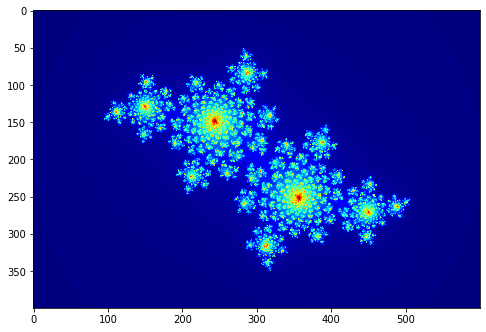

CPU times: user 1.61 s, sys: 36.3 ms, total: 1.64 s
Wall time: 1.64 s


In [3]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255
c = -0.4 - 0.60j

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    z = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    n = 0
    while abs(z) < 2 and n < iterations:
        z = mandelbrot(z, c)
        n += 1
    image[j, i] = n

# Display image
plt.imshow(image)
plt.show();

Or we could set the $c$ constant and start at $z = 0$ for each pixel (mandelbrot set)

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

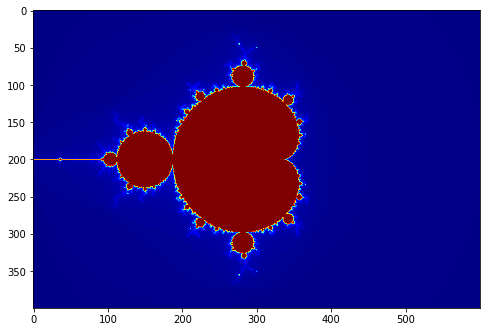

CPU times: user 3.75 s, sys: 50.6 ms, total: 3.8 s
Wall time: 3.8 s


In [4]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    c = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    z = 0
    n = 0
    while abs(z) < 2 and n < iterations:
        z = mandelbrot(z, c)
        n += 1
    image[j, i] = n
        
# Display image
plt.imshow(image)
plt.show();

## Burning Ship Fractal

Same general algorithm as Mandelbrot set, but a slight tweak to the formula:

$$
z_{n+1} = (|\Re(z_i)| + i|\Im(z_i)|)^2 + c
$$

Each part of the z value is set to their respective absolute values.

In [5]:
def burning_ship(z, c):
    za = complex(abs(z.real), abs(z.imag))
    return za*za + c

Juliaset fractal

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

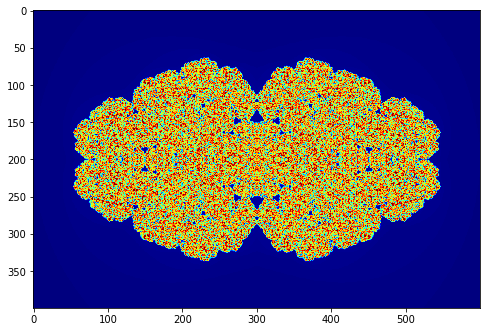

CPU times: user 9.44 s, sys: 103 ms, total: 9.54 s
Wall time: 9.5 s


In [6]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255
c = -1.0 - 0.55j

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    z = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    n = 0
    while abs(z) < 2 and n < iterations:
        z = burning_ship(z, c)
        n += 1
    image[j, i] = n

# Display image
plt.imshow(image)
plt.show();

And mandelbrot fractal

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

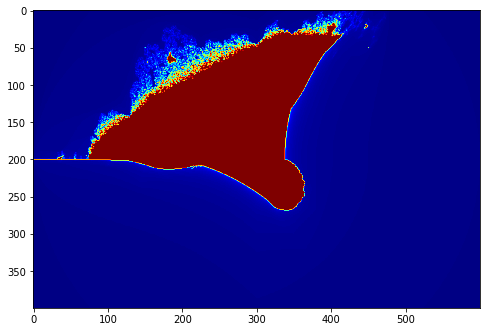

CPU times: user 6.6 s, sys: 85.1 ms, total: 6.68 s
Wall time: 6.67 s


In [7]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    c = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    z = 0
    n = 0
    while abs(z) < 2 and n < iterations:
        z = burning_ship(z, c)
        n += 1
    image[j, i] = n
        
# Display image
plt.imshow(image)
plt.show();

## Polynomial Roots Fractal Using Newton's method

Define complex polynomial function $f(z)$ and find roots of function using Newton's method

$$
z_{n+1} = z_n - \frac{f(z_n)}{f'(z_n)}
$$

We can define the function based on the roots

$$
f(z) = (z - r_1)(z - r_2)(z - r_3) = \prod_{i=1}^D{z - r_i}
$$

$D$ is the degree of the polynomial

We can use the product rule to differentiate in this form. The product rule has a useful symmetry that we can exploit

$$
(p r q)' = p'rq + p r'q + p r q' + ...
$$

Since $p$, $q$, and $r$ all take the form of $z - c$ (where $c$ is a constant), each of their individual derivatives reduces to $1$. So we can rewrite the derivative as follows

$$
f'(z) = (z - r_2)(z - r_3) + (z - r_1)(z - r_3) + (z - r_2)(z - r_3)
$$

More generally we could construct this formula

$$
f'(z) = \sum_{i=1}^D{ \prod_{j \neq i}{z - r_j} }
$$

In numpy, we're representing a polynomial by an array of roots. 

```
r = np.array([ r1, r2, r3, ... ])
```

The output of the polynomial given a `z` input is written as 

```
(z - r).prod()
```

The derivative is a bit trickier. Since we have two aggregate functions, we could start with a meshgrid array of the terms in `z - r`

```
d = r.shape[0]
p = z - r
pp = np.meshgrid(p, p)[0]
```

$$
\text{pp} = \begin{bmatrix}
z - r_1 & z - r_2 & z - r_3 & ... \\
z - r_1 & z - r_2 & z - r_3 & ... \\
z - r_1 & z - r_2 & z - r_3 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

The final derivative is a sum of a product. Looking at the formula above, we note that each product must contain only terms where $i \neq j$, which means terms on the diagonals. So, we multiply our terms using a sort of "opposite" identity matrix to filter everything off the diagonal

$$
(1 - \text{I}) = \begin{bmatrix}
0 & 1 & 1 & ... \\
1 & 0 & 1 & ... \\
1 & 1 & 0 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

```
pp *= (1 - np.eye(d))
```

$$
\text{pp} = \begin{bmatrix}
0 & z - r_2 & z - r_3 & ... \\
z - r_1 & 0 & z - r_3 & ... \\
z - r_1 & z - r_2 & 0 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

Since we're doing a product, there shouldn't be zero terms, since that will cause all terms to go to $0$. So we replace the zero terms along the diagonal with $1$ by adding another identity matrix

```
pp += np.eye(d)
```

$$
\text{pp} = \begin{bmatrix}
1 & z - r_2 & z - r_3 & ... \\
z - r_1 & 1 & z - r_3 & ... \\
z - r_1 & z - r_2 & 1 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

We can then take a product over the rows and finally sum the resulting terms, giving us the final derivative formula.

```
pp.prod(axis=1).sum()
```

In [8]:
%%time

def newtons_method(z, r):
    """
    Iterate z through one step of newton's method
    
    :param z: argument (being updated towards 0)
    :param r: polynomial roots array
    """
    d = r.shape[0] # Dimension of array
    p = z - r # Polynomial product terms array
    pp = np.meshgrid(p, p)[0] * (1 - np.eye(d)) + np.eye(d) # Derivative terms matrix
    return z - p.prod()/pp.prod(axis=1).sum() # New value of z from Newton's method

# Return index of root nearest to z given array of roots r
arg_nearest_root = lambda z, r: np.argmin(np.abs(z - r))


# Test with following roots
roots = np.array([ 1, np.sqrt(2)*(-1 + 1j), np.sqrt(2)*(-1 - 1j) ])
seeds = [ 0, 1, -1, 0.25j, -2j, 2j, -10 ]
final = []
for seed in seeds:
    z = seed
    for i in range(256):
        z = newtons_method(z, roots)
    final.append(z)
    
print('Seed', 'Final', sep='\t')
for seed, fina in zip(seeds, final):
    print(seed, fina, sep='\t')
print()

Seed	Final
0	(1+0j)
1	(1+0j)
-1	(1+0j)
0.25j	(1+0j)
(-0-2j)	(-1.4142135623730951-1.4142135623730951j)
2j	(-1.4142135623730951+1.4142135623730951j)
-10	(1+0j)

CPU times: user 88.2 ms, sys: 8.89 ms, total: 97.1 ms
Wall time: 90.4 ms


If we run the iteration for a grid of complex numbers and color them based on the root that they landed on. We can see a fractal pattern emerge.

Note: This particular fractal is very expensive to run, so it's being run multithreaded

In [ ]:
%%time

# Parameters
size = 600, 400
iterations = 16
thread_count = 12

# Image buffer
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Polynomial from complex roots
roots = np.array([ 1, np.sqrt(2)*(-1 + 1j), np.sqrt(2)*(-1 - 1j) ])

# Progress bar
progress_lock = threading.Lock()
progress = tqdm(total=size[0]*size[1] - 1, desc='Generating')

def thread_worker(pixel):
    """
    Run newton's method for given pixel coordinates
    Set image result to the nearest root that parameter lands on
    """
    global image
    i, j = pixel
    z = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    for _ in range(iterations):
        z = newtons_method(z, roots)
    image[j, i] = arg_nearest_root(z, roots)
    with progress_lock:
        progress.update()
        
# Map image iterations using thread pool executor
with conc.ThreadPoolExecutor(max_workers=thread_count) as exe:
    exe.map(thread_worker, image_range(size))
with progress_lock:
    progress.close()
    
# Show image
image = np.linspace(0, 1, roots.shape[0])[image]
plt.imshow(image);
plt.show();

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]